In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys
sys.path.append(os.path.abspath('../../visualization'))
from plotters import plot_gp, plot_gpkf

from sklearn import preprocessing

from params import Params
from gpkf import Gpkf
from generateSyntheticData import generateSyntheticData
#from plotters import plot_gp, plot_gp_example, plot_residuals

In [2]:
df = pd.read_csv('../../data/mergedData.csv')
df.set_index('Timestamp', inplace=True)
df.index = pd.to_datetime(df.index)
df.index = np.around(df.index.to_julian_date() * 24 * 60)
df.index = df.index - df.index[0]

In [3]:
center_df = df[[col for col in df.columns if 'Pos1' in col and 'DO' in col]].dropna(axis = 0, how = 'all')
#center_df = df['Pos1m3DO'].dropna(axis=0)
#center_df

In [4]:
def start_train(df):
    params = Params(df, 'fornes')
    model = Gpkf(params)

    #F, Y, noiseVar = generateSyntheticData(params.data)
    print('Formatting data')
    
    F = df.loc[params.data['timeInstants']].to_numpy().T
    Y = df.to_numpy().T[params.data['spaceLocsMeasIdx']]
    Y_mean = Y.mean(axis=0)
    Y = (Y - Y.mean(axis=0)) / Y.std(axis=0)
    
    noiseVar = (params.data['noiseStd'] * np.abs(Y))**2
    noiseVar[np.isnan(noiseVar)] = np.inf
    noiseVar[Y==0] = params.data['noiseStd']**2
    
    #F, Y, noiseVar = generateSyntheticData(params.data)
    #Y_mean = Y.mean(axis=0)
    #Y = (Y - Y.mean(axis=0)) / Y.std(axis=0)
    
    # Optimize parameters
    print('Optimizing parameters (log-marginal)')
    model.optimize(Y, noiseVar, params.optimizer_restarts)
    
    # GPKF estimate
    print('GPKF estimation')
    posteriorMean, posteriorCov, logMarginal = model.estimation(Y, noiseVar)

    #GPKF prediction
    print('GPKF prediction')
    predictedMean, predictedCov = model.prediction(Y, noiseVar)
    
    #plot_gpkf(params.data['spaceLocsMeas'], params.data['spaceLocsMeasIdx'], F[:,-1][params.data['spaceLocsMeasIdx']], posteriorMean[:,-1], posteriorCov[:,:,-1])
    plot_gpkf(params.data['spaceLocsPred'], [3,6,9,12], F[:,-1], predictedMean[:,-1] + Y_mean[-1], predictedCov[:,:,-1])
    #plot_gpkf(np.arange(0, params.data['spaceLocsPredIdx'].size), np.arange(0,params.data['spaceLocsPredIdx'].size), F[:,-1][params.data['spaceLocsPredIdx']], predictedMean[:,-1], predictedCov[:,:,-1])

    return model

In [5]:
#model = start_train(center_df)
params = Params(center_df, 'fornes')
model = Gpkf(params)

#F, Y, noiseVar = generateSyntheticData(params.data)
print('Formatting data')

F = center_df.loc[params.data['timeInstants']].to_numpy().T
Y = center_df.to_numpy().T[params.data['spaceLocsMeasIdx']]
Y_mean = np.nanmean(Y, axis=0)
Y_std = np.nanstd(Y, axis=0)
Y = (Y - Y_mean) / Y_std
#Y = preprocessing.scale(Y)

noiseVar = (params.data['noiseStd'] * np.abs(Y))**2
noiseVar[np.isnan(noiseVar)] = np.inf
noiseVar[Y==0] = params.data['noiseStd']**2

Using fornes dataset
Formatting data


In [6]:
# Optimize parameters
print('Optimizing parameters (log-marginal)')
#model.optimize(Y, noiseVar, params.optimizer_restarts)

Optimizing parameters (log-marginal)


In [7]:
# GPKF estimate
print('GPKF estimation')
posteriorMean, posteriorCov, logMarginal = model.estimation(Y, noiseVar)

#GPKF prediction
print('GPKF prediction')
predictedMean, predictedCov = model.prediction(Y, noiseVar)

# Undo normalization
posteriorMean = Y_std * posteriorMean + Y_mean
posteriorCov = posteriorCov * Y_std**2
predictedMean = Y_std * predictedMean + Y_mean
predictedCov = predictedCov * Y_std**2

GPKF estimation
GPKF prediction


Text(0.5, 1.0, 'GPKF prediction')

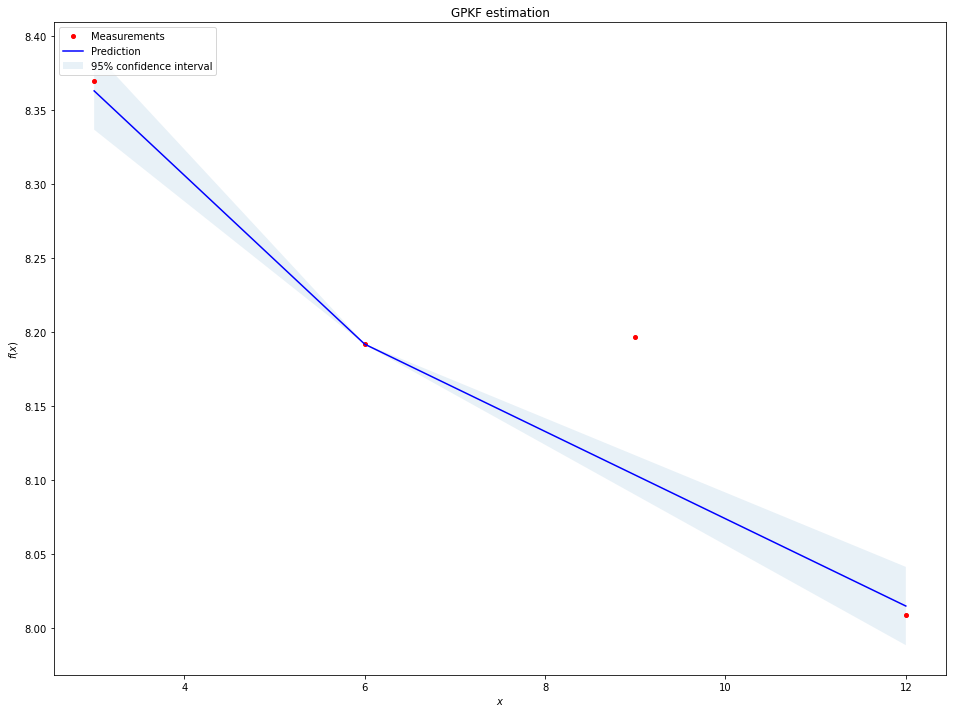

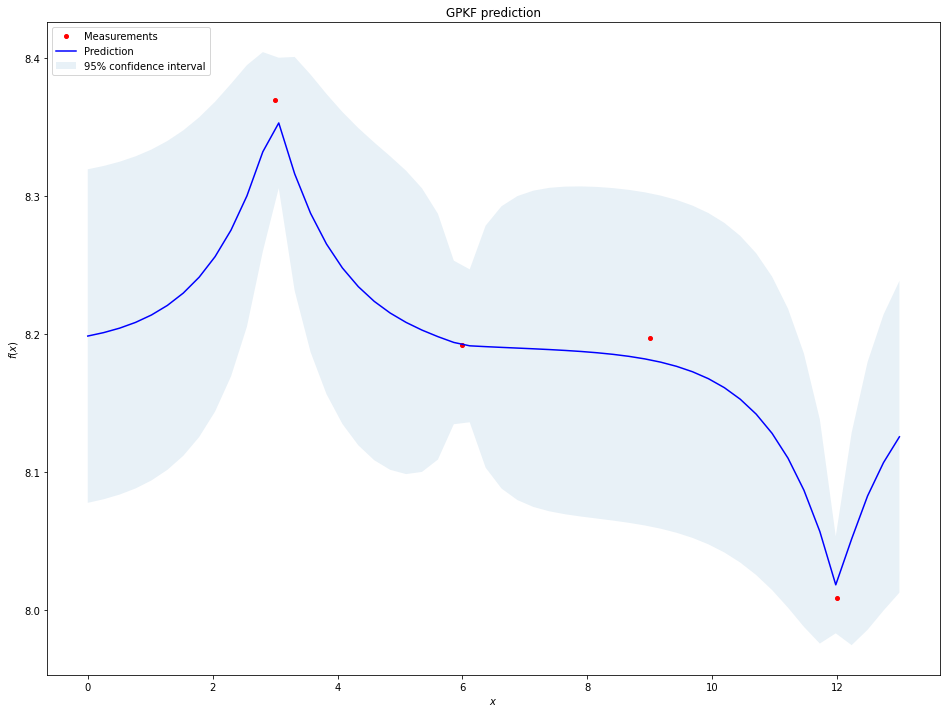

In [8]:
#plot_gpkf(params.data['spaceLocsMeas'], params.data['spaceLocsMeasIdx'], F[:,-1][params.data['spaceLocsMeasIdx']], posteriorMean[:,-1], posteriorCov[:,:,-1])
timeIndex = 2640
plot_gpkf(params.data['spaceLocsMeas'], [3,6,9,12], F[:,timeIndex], posteriorMean[:,timeIndex], posteriorCov[:,:,timeIndex])
plt.title('GPKF estimation')
plot_gpkf(params.data['spaceLocsPred'], [3,6,9,12], F[:,timeIndex], predictedMean[:,timeIndex], predictedCov[:,:,timeIndex])
plt.title('GPKF prediction')

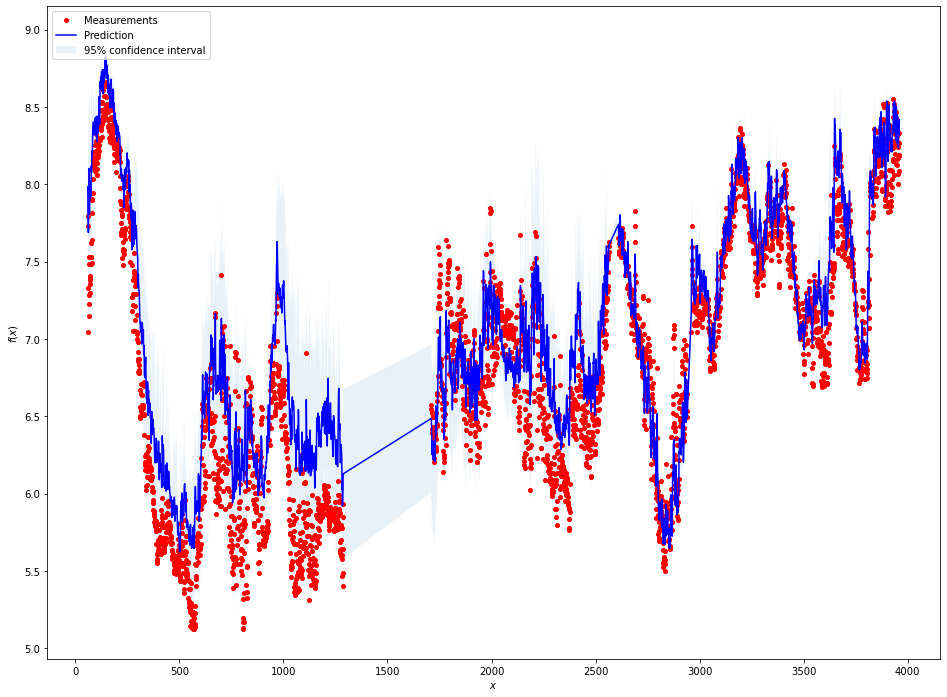

In [12]:
predIdx = 1
plot_gpkf(params.data['timeInstants'], params.data['timeInstants'], F[predIdx,:], predictedMean[predIdx,:], predictedCov[predIdx,predIdx,:])

In [10]:
np.argwhere(np.isnan(predictedMean[2,:]))
params.data['timeInstants'][2085]

2610.0